# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train) - min(y_train)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random as rand

def rand_visual(images, rows = 4, columns=16, fig = None, indices=None):
    '''
    Randomly show images from images
    
    Parameters:
        images: the image array
        rows: number of rows to show
        columns: number of columns to show
        grey: True if the images are greyscale
        fig: the matplotlib figure to show the images
    '''
    nTypes = len(images)
    nImages = len(images[1])
    if fig is None:
        fig = plt.figure()
        fig.set_size_inches(columns, rows*nTypes)

    for i in range(rows):
        if indices is None:
            rands = np.random.randint(nImages-1, size=columns)
        else:
            rands = indices[i]
        for j in range(nTypes):
            for k in range(min(len(rands), columns)):
                plot_idx = (nTypes*i + j) * columns + k + 1
                plt.subplot(rows*nTypes, columns, plot_idx)
                if len(images[j][rands[k]].shape) < 3:
                    plt.imshow(images[j][rands[k]], cmap='gray')
                else:
                    plt.imshow(images[j][rands[k]])
                

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
### Preprocessing functions
import cv2
import numpy as np

def randomize(image, scale):
    '''
    Randomize the image
    Parameters:
    image: the image
    scale: the scale of randomization
    '''
    noise = cv2.randu(np.empty(image.shape, dtype=np.float32), 0, scale)
    return noise + image

def normalize_grayscale(img):
    '''
    Normalize the grayscale image
    Parameter:
    a: the grayscale image to normalize
    Return: the normalized grayscale image
    '''
    if img.dtype != np.float32:
        img = np.array(img, dtype=np.float32)
    #return (img - np.mean(img)) / (np.std(img) + 1e-2)
    min = np.amin(img)
    max = np.amax(img)
    mid = (max + min) / 2
    dis = (max - min + 1) / 2 # +1 in case min = max
    return (img - mid) / dis

def grayscale(img):
    '''
    Convert the image to grayscale
    Parameter:
    img: the image to convert to grayscale
    Return: the converted grayscale image
    
    '''
    return cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

def normal_gray(images, randomize_scale=None):
    '''
    Convert the images into normalized grayscale images for processing
    Parameters:
    images: an array of RGB images
    Returns: an array of normalized grayscale images
    '''
    if randomize_scale is not None:
        return np.array([normalize_grayscale(randomize(grayscale(img), randomize_scale)) for img in images], dtype=np.float32)
    else:
        return np.array([normalize_grayscale(grayscale(img)) for img in images], dtype=np.float32)


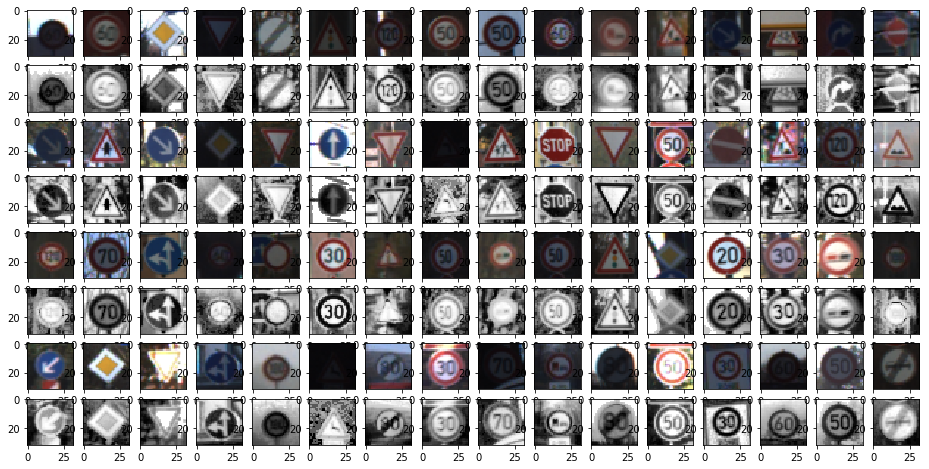

In [5]:
# Preprocess images, and visualize images, and their normalized counterpart

import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

train = normal_gray(X_train)
rand_visual([X_train, train])

### Model Architecture

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import glob
import re
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

def LeakyReLu(x, alpha=0.05):
    '''
    Leaky ReLu from Keras's Tensorflow backend implementation 
    alpha: slope of negative section.
    '''
    return tf.nn.relu(x) - tf.constant(alpha,dtype=tf.float32)*tf.nn.relu(-x)

def kernel_stride(s, data_format='NCHW'):
    '''
    Create kernel or strides fot the given data format
    Parameters:
    s: the kernel or stride size
    data_format: the data format, either 'NCHW' or 'NHWC'. Default is 'NCHW'
    '''
    if data_format == 'NCHW':
        return [1, 1, s, s]
    else:
        return [1, s, s, 1]
    
def weights(shape, name, initializer=tf.contrib.layers.xavier_initializer()):
    '''
    Create a new weight variable
    Parameters:
    shape: shape of the variable
    name: name of the variable
    initializer: initializer for the variable, default is xavier initializer
    '''
    return tf.get_variable(name, shape=shape, initializer=initializer)

def biases(shape, name, initializer=tf.zeros_initializer()):
    '''
    Create a new bias variable
    Parameter:
    shape: shape of the variable
    name: name of the variable
    initializer: initializer for the variable, default is zeros initializer
    '''
    return tf.get_variable(name, shape=shape, initializer=initializer)

def layer_counter():
    '''
    Return the current layer count, this is used to generate unique names
    '''
    if "index" not in layer_counter.__dict__: layer_counter.index = 0
    layer_counter.index += 1
    return layer_counter.index
    
def conv2d(x, shape, strides, data_format='NCHW', padding='SAME'):
    '''
    Create a new convolution layer
    Parameters:
    x: the input
    shape: shape of the kernel
    strides: the strides
    data_format: the data format, either 'NCHW' or 'NHWC'. Default is 'NCHW'
    padding: the padding
    '''
    layer = layer_counter()
    weight = weights(name='Wconv{}'.format(layer), shape=shape)
    bias = biases(name='Bconv{}'.format(layer), shape=shape[-1:])
    logits = tf.nn.conv2d(x, weight, strides=strides, data_format=data_format, padding=padding)
    logits = tf.nn.bias_add(logits, bias, data_format=data_format)
    logits = LeakyReLu(logits)
    return logits

def fcnn(x, shape, keep_prob=None):
    '''
    Create a fully connection network layer
    Parameters:
    x: the inputs layer
    shape: shape of the kernel
    keep_prob: dropout's keep proability. The layer if not have dropout if keep_prob is None
    '''
    layer = layer_counter()
    weight = weights(name='Wfcnn{}'.format(layer), shape=shape)
    bias = biases(name='Bfcnn{}'.format(layer), shape=shape[-1:])
    logits = tf.add(tf.matmul(x, weight), bias)
    logits = tf.nn.tanh(logits)
    if keep_prob != None:
        logits = tf.nn.dropout(logits, keep_prob)
    return logits
    
def CNN(x, classes, keep_prob=None, data_format='NCHW'):
    '''
    Create our 7-layer CNN model composed of 4 convolutiuon layers and 3 fully connected layers
    Parameters:
    x: the inputs layer
    classes: the number of classes
    keep_prob: dropout's keep proability. The layer if not have dropout if keep_prob is None
    data_format: the data format, either 'NCHW' or 'NHWC'. Default is 'NCHW'
    '''
    kernel_stride2 = kernel_stride(2, data_format=data_format)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x16.
    logits = conv2d(x, shape=(3, 3, 1, 16), strides=[1,1,1,1], data_format=data_format)
    
    # Layer 2: Convolutional. Input = 32x32x16 output = 32x32x32
    logits = conv2d(logits, shape=(3, 3, 16, 32), strides=[1,1,1,1], data_format=data_format)
    
    # Layer 3: Convolutional. Input = 32x32x32 output = 32x32x64
    logits = conv2d(logits, shape=(3, 3, 32, 64), strides=[1,1,1,1], data_format=data_format)
    
    # Pooling. Input = 32x32x64. Output = 16x16x64.
    logits = tf.nn.max_pool(logits, ksize=kernel_stride2, strides=kernel_stride2, data_format=data_format, padding='SAME')
    
    # Layer 4: Convolutional. Input = 16x16x64, Output = 14x14x96.
    logits = conv2d(logits, shape=(3, 3, 64, 96), strides=[1,1,1,1], data_format=data_format, padding='VALID')
    
    # Pooling. Input = 14x14x96. Output = 7x7x96.
    logits = tf.nn.max_pool(logits, ksize=kernel_stride2, strides=kernel_stride2, data_format=data_format, padding='SAME')
    
    # TODO: Flatten. Input = 7x7x96. Output = 4704.
    logits = flatten(logits)
    
    logits = tf.nn.dropout(logits, keep_prob)
    
    # Layer 5: Fully Connected. Input = 4704. Output = 1600.
    logits = fcnn(logits, shape=(4704, 1600), keep_prob=keep_prob)
    
    # Layer 6: Fully Connected. Input = 1600. Output = 400.
    logits = fcnn(logits, shape=(1600, 400), keep_prob=keep_prob)
    
    # Layer 7: Fully Connected. Input = 400. Output = nclasses.
    logits = fcnn(logits, shape=(400, classes))
    
    return logits

class CNNModel:
    def __init__(self, features, labels, classes, keep_prob, logits):
        self.features = features
        self.labels = labels
        self.classes = classes
        self.keep_prob = keep_prob
        self.logits = logits
        
def create_model(feature_shape, classes, feature_dtype=tf.float32, label_dtype=tf.int32): 
    '''
    Re-initializeTensorflow environment and create the core network model
    Parameters:
    feature_shape: shape of the features
    classes" classes of the features
    feature_dtype: features's data type, default is float32
    label_dtype: label's data type, default is int32
    '''
    tf.reset_default_graph()
    if feature_shape[0] < feature_shape[1] and feature_shape[0] < feature_shape[2]:
        data_format='NCHW'
    else:
        data_format='NHWC'
    x = tf.placeholder(feature_dtype, (None,) + feature_shape)
    y = tf.placeholder(label_dtype, (None))
    keep_prob = tf.placeholder(tf.float32)
    logits = CNN(x, classes=classes, keep_prob=keep_prob, data_format=data_format)
    tf.add_to_collection("features", x)
    tf.add_to_collection("labels", y)
    tf.add_to_collection("keep_prob", keep_prob)
    tf.add_to_collection("model", logits)
    return CNNModel(x, y, classes, keep_prob, logits)

def save_current_model(name):
    '''
    Save the current Tensorflow model
    Parameter:
    name: checkpoint name of the model
    '''
    tf.train.export_meta_graph(filename=name+'.meta', clear_devices=True)

def load_model(name, classes):
    '''
    Loade current Tensorflow model
    Parameter:
    name: checkpoint name of the model
    '''
    tf.reset_default_graph()
    saver = tf.train.import_meta_graph(name + '.meta')
    graph = tf.get_default_graph()
    features = graph.get_collection('features')[0]
    labels = graph.get_collection('labels')[0]
    keep_prob = graph.get_collection('keep_prob')[0]
    logits = graph.get_collection('model')[0]
    return CNNModel(features, labels, classes, keep_prob, logits)

def save_trained_model(session, checkpoint, step = None, saver = None):
    '''
    Save the trained model
    Parameters:
    session: the current tensorflow training session
    checkpoint: name of the checkpoint (the file name prefix of files where the trained model is saved)
    step: the step (epoch) in which the model was trained
    saver: the saver object to use, a new saver will be used if None is given
    '''
    if saver == None:
        saver = tf.train.Saver()
    saver.save(session, checkpoint, global_step=step)
    
def load_trained_model(session, checkpoint, classes):
    '''
    Loade trained model
    Parameters:
    session: the tensorflow session to restore the trained model to
    checkpoint: name of the checkpoint (the file name prefix of files where the trained model is to be loaded)
    classes: classes of the model's labels
    '''
    saver = tf.train.import_meta_graph(checkpoint + '.meta')
    saver.restore(session, checkpoint)
    graph = tf.get_default_graph()
    features = graph.get_collection('features')[0]
    labels = graph.get_collection('labels')[0]
    keep_prob = graph.get_collection('keep_prob')[0]
    logits = graph.get_collection('model')[0]
    return CNNModel(features, labels, classes, keep_prob, logits)

def find_trained_model(path, checkpoint_prefix):
    '''
    Find the list of checkpoint models, return the checkpoint names of the trained model of format: 'path/checkpoint_prefix-nn'
    path: path
    checkpoint_prefix: checkpoint name's prefix
    '''
    files = glob.glob('{0}/{1}-*.meta'.format(path, checkpoint_prefix))
    if files == None or len(files) == 0:
        print("No trained model found in {0}/{1}!".format(path, checkpoint_prefix))
        return None
    else:
        # Extract the checkpoint to use
        files.sort(key=os.path.getmtime)
        return [file[:-5] for file in reversed(files)]
    
def create_training(cnn, learning_rate, global_step=None):
    '''
    Create the training model from the core network model. It uses adam optimizer for training the model
    Parameters:
    logits: the core network model
    labels: the labels
    classes: the number of label classes
    learning_rate: the learning rate
    global_step: the global step, default is None
    '''
    one_hot_y = tf.one_hot(cnn.labels, cnn.classes)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=cnn.logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    return optimizer.minimize(loss_operation, global_step=global_step)

def create_evaluation(cnn):
    '''
    Create evaluation model from the core model
    Parameters:
    cnn: the CNN model
    '''
    one_hot_y = tf.one_hot(cnn.labels, cnn.classes)
    correct_prediction = tf.equal(tf.argmax(cnn.logits, 1), tf.argmax(one_hot_y, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def create_prediction(cnn):
    '''
    Create prediction model from the core model
    Parameters:
    cnn: the CNN model
    '''
    one_hot_y = tf.one_hot(cnn.labels, cnn.classes)
    correct_prediction = tf.argmax(cnn.logits, 1)
    return correct_prediction

def create_softmax_evaluation(cnn, n=5):
    '''
    Create softmax evaluation model from the core model
    Parameters:
    cnn: the CNN model
    '''
    softmax = tf.nn.softmax(cnn.logits)
    return softmax, tf.nn.top_k(softmax, n)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [7]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

def evaluate(session, features, labels, operation, cnn, batch_size=256):
    '''
    Evaluate the current training model
    Parameters:
    session: the current session
    features: the features to evaluate
    labels: labels of the features
    operation: the evaluation operation
    cnn: the CNN model
    batch_size: the batch processing size, default is 256
    '''
    num_examples = len(features)
    total_accuracy = 0
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = features[offset:offset+batch_size], labels[offset:offset+batch_size]
        accuracy = session.run(operation, feed_dict={cnn.features: batch_x, cnn.labels: batch_y, cnn.keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def train_model(features, labels, valid, y_valid, checkpoint, dropout_keep_prob = 0.85, repeats=1, learning_rate = 0.0006, 
                epochs = 60, batch_size = 256, accept=0.98):
    '''
    This is a generator for generating the best training models. Create and train a CNN model with the features, and saves the
    best training models in checkpoint for prediction operations. The generator will yield everytime a best training model is
    generated.
    
    Parameters:
    features: the features to train
    labels: labels of the features
    valid: the validation data
    y_valid: the labels of the validation data
    checkpoint: the base name of the checkpoints where the best training models will be saved
    dropout_keep_prob: the keep probability of drop out
    repeats: number of training to perform for the best model
    learning_rate: thje learning rate
    epochs: the number of epochs for each training
    batch_size: the batch size
    goal: goal of the training accuracy to get
    accept: the minimal accuracy to accept for a training model
    '''
    save_id = 0
    count = 0
    
    cnn = create_model(features.shape[1:], int(n_classes))

    training_operation = create_training(cnn, learning_rate)
    accuracy_operation = create_evaluation(cnn)

    while count < repeats:
        count += 1
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())
            print("Training {} ...".format(count))
            for i in range(epochs):
                features, labels = shuffle(features, labels)
                for offset in range(0, n_train, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = features[offset:end], labels[offset:end]
                    session.run(training_operation, feed_dict={cnn.features: batch_x, cnn.labels: batch_y, cnn.keep_prob: dropout_keep_prob})

                validation_accuracy = evaluate(session, valid, y_valid, accuracy_operation, cnn)
                print("EPOCH {0:3}: Accuracy = {1:.3f}".format(i+1, validation_accuracy))
                if validation_accuracy >= accept:
                    save_id += 1
                    for retry in range(3):
                        try:
                            save_trained_model(session, model_file_name, step = save_id)
                            break
                        except:
                            print("Failed to save trained model!")
                            time.sleep(2)
                    yield validation_accuracy, save_id

In [8]:
import time

EPOCHS = 100
BATCH_SIZE = 256
learning_rate = 0.0006
model_file_name = './trained/traffic_signs'
training_goal = 0.99
accept = 0.985
best_index = -1

# Prepare the training and validation data 
train = train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
valid = normal_gray(X_valid)
valid = valid.reshape((X_valid.shape[0], 1, X_valid.shape[1], X_valid.shape[2]))

start_time = time.time()

# Train the model with the training and validation data
for accuracy, best_index in train_model(train, y_train, valid, y_valid, dropout_keep_prob=0.6, repeats=10, checkpoint=model_file_name, 
                learning_rate=learning_rate, epochs=EPOCHS, batch_size=BATCH_SIZE, accept=accept):
    print("Best trained model saved in: {0}-{1} with accuracy: {2:.3f}".format(model_file_name, best_index, accuracy))
    if accuracy >= training_goal:
        break

print("Total training time: {:.3} seconds".format((time.time() - start_time)))

Training 1 ...
EPOCH   1: Accuracy = 0.837
EPOCH   2: Accuracy = 0.904
EPOCH   3: Accuracy = 0.938
EPOCH   4: Accuracy = 0.957
EPOCH   5: Accuracy = 0.967
EPOCH   6: Accuracy = 0.963
EPOCH   7: Accuracy = 0.965
EPOCH   8: Accuracy = 0.970
EPOCH   9: Accuracy = 0.974
EPOCH  10: Accuracy = 0.971
EPOCH  11: Accuracy = 0.973
EPOCH  12: Accuracy = 0.973
EPOCH  13: Accuracy = 0.975
EPOCH  14: Accuracy = 0.978
EPOCH  15: Accuracy = 0.978
EPOCH  16: Accuracy = 0.976
EPOCH  17: Accuracy = 0.978
EPOCH  18: Accuracy = 0.978
EPOCH  19: Accuracy = 0.974
EPOCH  20: Accuracy = 0.980
EPOCH  21: Accuracy = 0.980
EPOCH  22: Accuracy = 0.981
EPOCH  23: Accuracy = 0.978
EPOCH  24: Accuracy = 0.978
EPOCH  25: Accuracy = 0.979
EPOCH  26: Accuracy = 0.980
EPOCH  27: Accuracy = 0.978
EPOCH  28: Accuracy = 0.980
EPOCH  29: Accuracy = 0.976
EPOCH  30: Accuracy = 0.978
EPOCH  31: Accuracy = 0.980
EPOCH  32: Accuracy = 0.980
EPOCH  33: Accuracy = 0.981
EPOCH  34: Accuracy = 0.980
EPOCH  35: Accuracy = 0.978
EPOCH

In [9]:
# Load the trained model, and test the model on the test images
import time
model_file_name = './trained/traffic_signs'

best_test_model = None
best_accuracy = 0.0

# Prepare the test data
test = normal_gray(X_test)
test = test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]))

start_time = time.time()
for trained in find_trained_model('./trained', 'traffic_signs'):
    print("Trained model: {}".format(trained))
    # Initialize the Tensorflow environment
    tf.reset_default_graph()
    with tf.Session() as session:
        # Load the pre-trained model
        cnn = load_trained_model(session, trained, n_classes)
        # Create the accuracy perdiction
        accuracy_operation = create_evaluation(cnn)
        # Evaluate the test data against the pre-trained data
        test_accuracy = evaluate(session, test, y_test, accuracy_operation, cnn)
        if best_accuracy < test_accuracy:
            best_test_model = trained
            best_accuracy = test_accuracy
        print("\tTest accuracy for {0} samples = {1:.3f}".format(len(test), test_accuracy))
print("\tTest time {:.3} seconds".format((time.time() - start_time)))


Trained model: ./trained\traffic_signs-71
	Test accuracy for 12630 samples = 0.971
Trained model: ./trained\traffic_signs-70
	Test accuracy for 12630 samples = 0.975
Trained model: ./trained\traffic_signs-69
	Test accuracy for 12630 samples = 0.974
Trained model: ./trained\traffic_signs-68
	Test accuracy for 12630 samples = 0.974
Trained model: ./trained\traffic_signs-67
	Test accuracy for 12630 samples = 0.976
Trained model: ./trained\traffic_signs-66
	Test accuracy for 12630 samples = 0.975
Trained model: ./trained\traffic_signs-65
	Test accuracy for 12630 samples = 0.974
Trained model: ./trained\traffic_signs-64
	Test accuracy for 12630 samples = 0.975
Trained model: ./trained\traffic_signs-63
	Test accuracy for 12630 samples = 0.974
Trained model: ./trained\traffic_signs-62
	Test accuracy for 12630 samples = 0.973
Trained model: ./trained\traffic_signs-61
	Test accuracy for 12630 samples = 0.973
Trained model: ./trained\traffic_signs-60
	Test accuracy for 12630 samples = 0.972
Trai

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

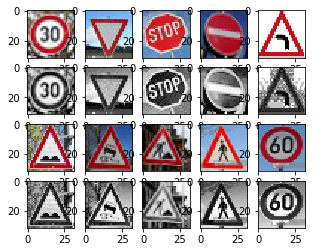

In [36]:
### Load the images and plot them here.
best_test_model='./trained/traffic_signs-59'
if best_test_model != None: # we have training model to use
    # Load images
    files = glob.glob('./examples/traff-*.jpg')
    extras = np.array([cv2.cvtColor(cv2.imread(file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for file in files])
    labels = [int(re.findall('\d+', file)[0]) for file in files]
    images = normal_gray(extras)
    rand_visual([extras, images], rows=2, columns=5, indices=[[0, 1, 2, 3, 4],[5, 6, 7, 8, 9]])
    

### Predict the Sign Type for Each Image

In [37]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

if best_test_model != None: # we have training model to use
    print("Predict with best model: ", best_test_model)
    images = images.reshape((images.shape[0], 1, images.shape[1], images.shape[2]))

    # Initialize the Tensorflow environment
    tf.reset_default_graph()
    with tf.Session() as session:
            # Load the pre-trained model
            cnn = load_trained_model(session, best_test_model, n_classes)
            # Create the softmax evaluation operation
            prediction_operation = create_prediction(cnn)
            # Evaluate the test data against the pre-trained data
            prediction = session.run(prediction_operation, feed_dict={cnn.features: images, cnn.labels: labels, cnn.keep_prob:1.0})
            print("Prediction:\n", prediction)
            

Predict with best model:  ./trained/traffic_signs-59
Prediction:
 [ 1 13 14 17 19 22 23 25 27  3]


### Analyze Performance

In [38]:
### Calculate the accuracy for these 5 new images. 

if best_test_model != None: # we have training model to use
    tf.reset_default_graph()
    with tf.Session() as session:
            # Load the pre-trained model
            cnn = load_trained_model(session, best_test_model, n_classes)
            # Create the accuracy perdiction
            accuracy_operation = create_evaluation(cnn)
            # Evaluate the test data against the pre-trained data
            test_accuracy = evaluate(session, images, labels, accuracy_operation, cnn)
            print("\tTest for {0} samples = {1:.2f}%".format(len(images), test_accuracy*100))


	Test for 10 samples = 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [40]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

if best_test_model != None: # we have training model to use
    tf.reset_default_graph()        
    with tf.Session() as session:
            # Load the pre-trained model
            cnn = load_trained_model(session, best_test_model, n_classes)
            # Create the softmax evaluation operation
            softmax_operation = create_softmax_evaluation(cnn, 5)
            # Evaluate the test data against the pre-trained data
            softmax, softmax_performance = session.run(softmax_operation, feed_dict={cnn.features: images, cnn.labels: labels, cnn.keep_prob:1.0})
            print("Performance:\n", softmax_performance)

Performance:
 TopKV2(values=array([[ 0.15270092,  0.02066583,  0.02066583,  0.02066583,  0.02066583],
       [ 0.15270092,  0.02066584,  0.02066583,  0.02066583,  0.02066583],
       [ 0.15266936,  0.02077872,  0.02068128,  0.02066578,  0.02066451],
       [ 0.1527009 ,  0.02066587,  0.02066585,  0.02066584,  0.02066584],
       [ 0.152605  ,  0.02079302,  0.02072839,  0.02071092,  0.02069836],
       [ 0.15268853,  0.02067498,  0.0206741 ,  0.02066931,  0.02066769],
       [ 0.15231453,  0.02312745,  0.02062256,  0.02061454,  0.02061409],
       [ 0.15237199,  0.02268713,  0.02062407,  0.02062394,  0.0206235 ],
       [ 0.15265542,  0.02091638,  0.02068794,  0.02066276,  0.02066195],
       [ 0.15242928,  0.0208539 ,  0.0206685 ,  0.02066831,  0.02066792]], dtype=float32), indices=array([[ 1,  0, 21, 31, 32],
       [13, 32,  1,  6, 14],
       [14, 34,  8, 35,  7],
       [17, 36, 34,  9, 22],
       [19, 21, 11, 34, 23],
       [22, 23, 24, 25, 29],
       [23, 21, 30, 19, 22],
    

In [42]:
# Test accuracy for training data
train = normal_gray(X_train)
train = train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]))
if best_test_model != None: # we have training model to use
    tf.reset_default_graph()
    with tf.Session() as session:
            # Load the pre-trained model
            cnn = load_trained_model(session, best_test_model, n_classes)
            # Create the accuracy perdiction
            accuracy_operation = create_evaluation(cnn)
            # Evaluate the test data against the pre-trained data
            test_accuracy = evaluate(session, train, y_train, accuracy_operation, cnn)
            print("\tTest for {0} samples = {1:.2f}%".format(len(train), test_accuracy*100))

	Test for 34799 samples = 99.38%


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")